In [58]:
import os
import scipy.io
import numpy as np
from py12_spike_data_preprocess_utils import preprocess_spike_data, clean_spike_data_1, clean_spike_data_2
import neuralflow

brain_region_list = ['left_ALM', 'left_BLA', 'left_ECT', 'left_Medulla', 'left_Midbrain', 'left_Striatum', 'left_Thalamus'] +\
                    ['right_ALM', 'right_BLA', 'right_ECT', 'right_Medulla', 'right_Midbrain', 'right_Striatum', 'right_Thalamus']


In [59]:
brain_region = "left_Medulla"
date = 57
path = f"../data/raw_data/neural_data_{brain_region}/neural_data_{date}_{brain_region}.mat"
data = scipy.io.loadmat(path)
spike_counts_ori = data['region_data']
trial_counts_ori = data['trial_count'].squeeze()
num_neurons_ori = spike_counts_ori.shape[1]

In [70]:
num_neurons_ori, trial_counts_ori

(79, 197)

In [60]:
# # 现在的错误在于，单独一个spiketime可以有全是0的情况

# num_trials= 100
# num_neurons = 5
# spike_counts_reshape_ori = spike_counts_ori.reshape((-1, trial_counts_ori, num_neurons_ori))
# spike_counts_reshape = spike_counts_reshape_ori[57:150,0:num_trials,:]
# spike_counts = spike_counts_reshape.reshape((-1, num_neurons_ori))
# time_epoch = [(0, 1.86)] * int(num_trials)  # convert trial_count to integer time interval list

# # 现在需要把两个数据集放在一起清理，保证留下来的神经元是一样的
# spike_counts_processed, _, _ = clean_spike_data_2(spike_counts, num_trials, time_epoch)
# spike_counts_processed = spike_counts_processed[:, 0:num_neurons]

# spiketimes, timeepoch = preprocess_spike_data(spike_counts_processed, num_trials, time_epoch)

# trial1 = np.arange(0, num_trials, 2)
# trial2 = np.arange(1, num_trials, 2)


# # ---------- Prepare first data sample ----------
# spiketimes1, timeepoch1 = spiketimes[:, trial1], [timeepoch[i] for i in trial1]
# data_1 = neuralflow.SpikeData(
#     data=spiketimes1, dformat='spiketimes', time_epoch=timeepoch1, with_cuda=True
# )
# data_1.change_format('ISIs')

# # ---------- Prepare second data sample ----------
# spiketimes2, timeepoch2 = spiketimes[:, trial2], [timeepoch[i] for i in trial2]
# data_2 = neuralflow.SpikeData(
#     data=spiketimes2, dformat='spiketimes', time_epoch=timeepoch2, with_cuda=True
# )
# data_2.change_format('ISIs')

In [61]:
# 现在换一种方法，手动清理神经元，可以防止上面的两种情况

# 最后约化的参数
num_trials= 5
num_neurons = 5

# 原始数据截取正确的时间段
spike_counts_reshape_ori = spike_counts_ori.reshape((-1, trial_counts_ori, num_neurons_ori))
spike_counts_reshape = spike_counts_reshape_ori[57:150,:,:]
spike_counts = spike_counts_reshape.reshape((-1, num_neurons_ori))
time_epoch = [(0, 1.86)] * int(trial_counts_ori)  # 原始数据的time_epoch

# 这边其实就需要clean_1, 要不然遇到极端情况会报错
spike_counts, trial_counts_ori, time_epoch = clean_spike_data_1(spike_counts, trial_count=trial_counts_ori, timeepoch=time_epoch)
spiketimes, timeepoch = preprocess_spike_data(spike_counts, trial_counts_ori, time_epoch)

# 定义实验用的trial
trial1 = np.arange(0, num_trials, 2)
trial2 = np.arange(1, num_trials, 2)

# 检查spiketimes中的数据，如果一个神经元在trial1或者在trial2中都不发放，那么需要把这个神经元剔除掉
non_zero_neurons = []
for neuron in range(num_neurons_ori):
    if not all(len(spiketimes[neuron, t]) == 0 for t in trial1) and not all(len(spiketimes[neuron, t]) == 0 for t in trial2):
        # 如果该神经元在两个实验中都没有发放，则剔除
        non_zero_neurons.append(neuron)

spiketimes = spiketimes[non_zero_neurons, :]


# ---------- Prepare first data sample ----------
spiketimes1 = spiketimes[0:num_neurons,trial1]
timeepoch1 = [timeepoch[i] for i in trial1]
data_1 = neuralflow.SpikeData(
    data=spiketimes1, dformat='spiketimes', time_epoch=timeepoch1, with_cuda=True
)
data_1.change_format('ISIs')

# ---------- Prepare second data sample ----------
spiketimes2 = spiketimes[0:num_neurons,trial2]
timeepoch2 = [timeepoch[i] for i in trial2]
data_2 = neuralflow.SpikeData(
    data=spiketimes2, dformat='spiketimes', time_epoch=timeepoch2, with_cuda=True
)
data_2.change_format('ISIs')


In [62]:
# ---------- Optimization for data_1 ----------
grid = neuralflow.GLLgrid(Np=8, Ne=16, with_cuda=True)
num_neurons = spiketimes1.shape[0]
init_model = neuralflow.model.new_model(
    peq_model={"model": "uniform", "params": {}},
    p0_model={"model": "cos_square", "params": {}},
    D=1,
    fr_model=[{"model": "linear", "params": {"slope": 1, "bias": 100}}] * num_neurons,
    params_size={'peq': 1, 'D': 1, 'fr': 1, 'p0': 1},
    grid=grid,
    with_cuda=True
)

optimizer = 'ADAM'
opt_params = {
    'max_epochs': 50,
    'mini_batch_number': 20,
    'params_to_opt': ['F', 'F0', 'D', 'Fr', 'C'],
    'learning_rate': {'alpha': 0.05}
}
ls_options = {
    'C_opt': {'epoch_schedule': [0, 1, 5, 30], 'nSearchPerEpoch': 3, 'max_fun_eval': 2},
    'D_opt': {'epoch_schedule': [0, 1, 5, 30], 'nSearchPerEpoch': 3, 'max_fun_eval': 25}
}
boundary_mode = 'absorbing'

optimization1 = neuralflow.optimization.Optimization(
    [data_1],
    init_model,
    optimizer,
    opt_params,
    ls_options,
    boundary_mode=boundary_mode,
    device='GPU'
)
print('Running optimization on datasample 1')
optimization1.run_optimization()

# ---------- Optimization for data_2 ----------
grid = neuralflow.GLLgrid(Np=8, Ne=16, with_cuda=True)
num_neurons = spiketimes2.shape[0]
init_model = neuralflow.model.new_model(
    peq_model={"model": "uniform", "params": {}},
    p0_model={"model": "cos_square", "params": {}},
    D=1,
    fr_model=[{"model": "linear", "params": {"slope": 1, "bias": 100}}] * num_neurons,
    params_size={'peq': 1, 'D': 1, 'fr': 1, 'p0': 1},
    grid=grid,
    with_cuda=True
)

optimization2 = neuralflow.optimization.Optimization(
    [data_2],
    init_model,
    optimizer,
    opt_params,
    ls_options,
    boundary_mode=boundary_mode,
    device='GPU'
)
print('Running optimization on datasample 2')
optimization2.run_optimization()

Running optimization on datasample 1


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


Running optimization on datasample 2


100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


In [63]:
from neuralflow.feature_complexity.fc_base import FC_tools

JS_thres = 0.0015
FC_stride = 5
smoothing_kernel = 10

fc = FC_tools(non_equilibrium=True, model=init_model, boundary_mode=boundary_mode, terminal_time=1)
FCs1, min_inds_1, FCs2, min_inds_2, JS, FC_opt_ind = fc.FeatureConsistencyAnalysis(
    optimization1.results, optimization2.results, JS_thres, FC_stride, smoothing_kernel
)
invert = fc.NeedToReflect(optimization1.results, optimization2.results)

In [64]:
# ---------- Plotting ----------
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# Create output folder figs/{brain_region}_{date}
output_folder = f"figs/{brain_region}_{date}"
os.makedirs(output_folder, exist_ok=True)

# Predefined colors for consistency
color_lines = ['#FF8C8C', [0.431, 0.796, 0.388], [1, 0.149, 0], [0, 0.561, 0]]

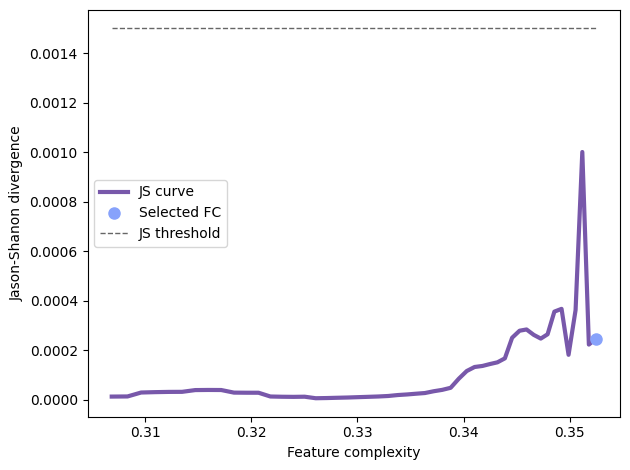

In [65]:
# -----------------------------
# Plot 1: JS divergence vs. Feature Complexity
plt.figure()
plt.plot(FCs1, JS, linewidth=3, color=[120/255, 88/255, 170/255], label='JS curve')
plt.plot(FCs1[FC_opt_ind], JS[FC_opt_ind], '.', markersize=16, color='#87A2FB', label='Selected FC')
plt.plot(FCs1, JS_thres * np.ones_like(FCs1), '--', linewidth=1, color=[0.4]*3, label='JS threshold')
plt.xlabel('Feature complexity')
plt.ylabel('Jason-Shanon divergence')
plt.legend()
plt.tight_layout()



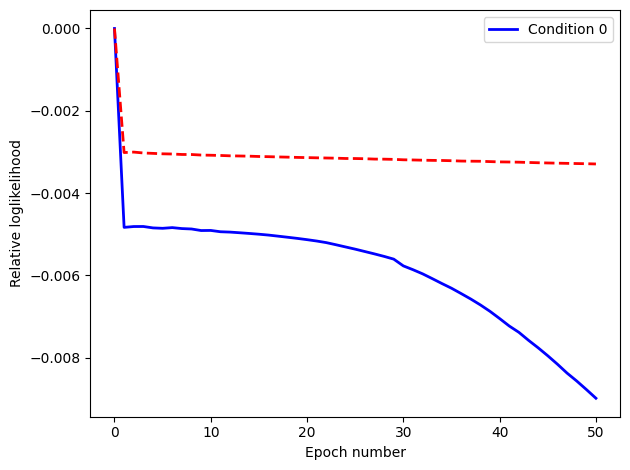

In [ ]:
plt.figure()
for cond in range(1):
    ll1 = optimization1.results['logliks'][cond]
    ll10 = ll1[0]
    ll1 = (ll1 - ll10) / np.abs(ll10)
    ll2 = optimization2.results['logliks'][cond]
    ll20 = ll2[0]
    ll2 = (ll2 - ll20) / np.abs(ll20)
    iter_nums = np.arange(len(ll1), dtype='float64')
    plt.plot(iter_nums, ll1, color='blue', linewidth=2, label='data1')
    plt.plot(iter_nums, ll2, color='red', linestyle='--', linewidth=2, label='data2')
plt.xlabel('Epoch number')
plt.ylabel('Relative loglikelihood')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'relative_loglikelihood.png'))

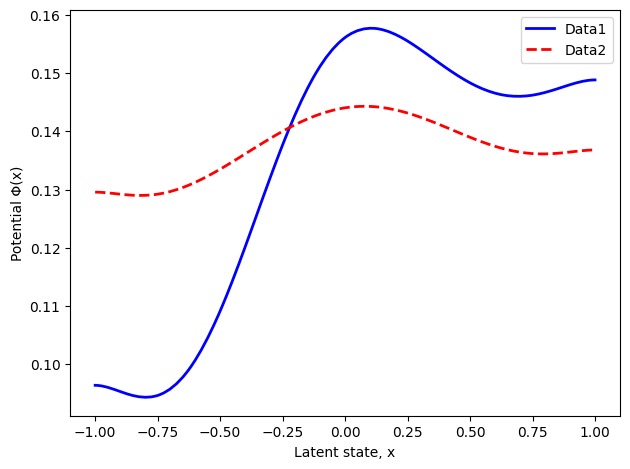

In [67]:
# Plot 3: Potential function (Phi) for each condition (here, only one condition)
for cond in range(1):
    plt.figure()
    opt_ind_1 = min_inds_1[FC_opt_ind]
    opt_ind_2 = min_inds_2[FC_opt_ind]
    Phi1 = -np.log(optimization1.results['peq'][opt_ind_1][cond]) * optimization1.results['D'][opt_ind_1][0]
    Phi2 = -np.log(optimization2.results['peq'][opt_ind_2][cond]) * optimization2.results['D'][opt_ind_2][0]
    plt.plot(init_model.grid.x_d, Phi1, linewidth=2, color='blue', label='Data1')
    plt.plot(init_model.grid.x_d, (Phi2[::-1] if invert else Phi2), linewidth=2, color='red', linestyle='--', label='Data2')
    plt.xlabel('Latent state, x')
    plt.ylabel('Potential Φ(x)')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(os.path.join(output_folder, f'potential_condition_{cond}.png'))
    

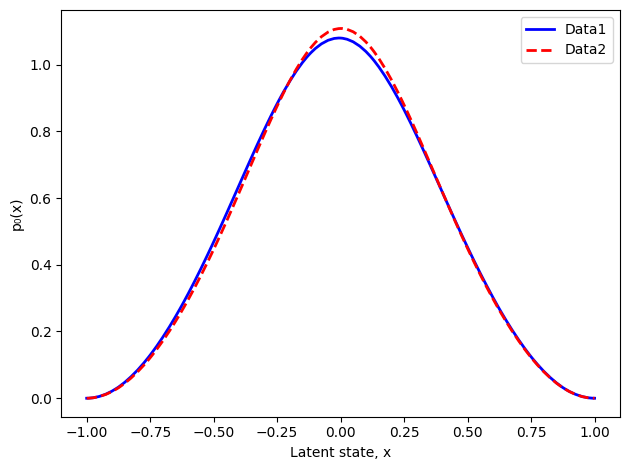

In [68]:
# Plot 4: p0 plot
plt.figure()
opt_ind_1 = min_inds_1[FC_opt_ind]
opt_ind_2 = min_inds_2[FC_opt_ind]
p0_1 = optimization1.results['p0'][opt_ind_1][0]
p0_2 = optimization2.results['p0'][opt_ind_2][0]
plt.plot(init_model.grid.x_d, p0_1, linewidth=2, color='blue', label='Data1')
plt.plot(init_model.grid.x_d, (p0_2[::-1] if invert else p0_2), linewidth=2, color='red', linestyle='--', label='Data2')
plt.xlabel('Latent state, x')
plt.ylabel('p₀(x)')
plt.legend()
plt.tight_layout()
# plt.savefig(os.path.join(output_folder, 'p0.png'))



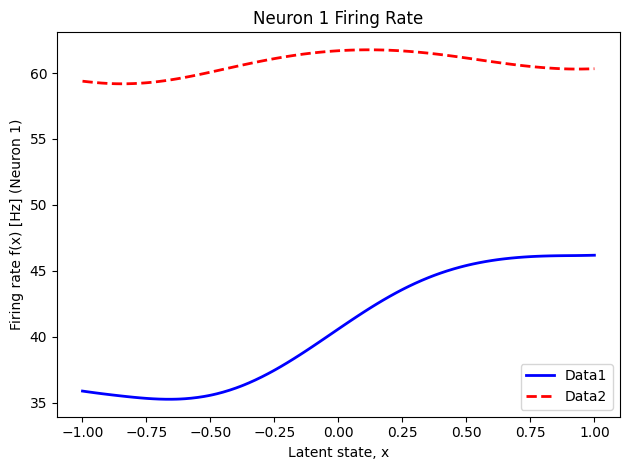

In [69]:
fr_shape = optimization1.results['fr'][opt_ind_1].shape
num_neurons = fr_shape[2]
n = 0
plt.figure()
fr1 = optimization1.results['fr'][opt_ind_1][0, :, n]
fr2 = optimization2.results['fr'][opt_ind_2][0, :, n]
plt.plot(init_model.grid.x_d, fr1, linewidth=2, color='blue', label='Data1')
plt.plot(init_model.grid.x_d, (fr2[::-1] if invert else fr2), linewidth=2, color='red', linestyle='--', label='Data2')
plt.xlabel('Latent state, x')
plt.ylabel(f'Firing rate f(x) [Hz] (Neuron {n+1})')
plt.title(f'Neuron {n+1} Firing Rate')
plt.legend()
plt.tight_layout()
# plt.savefig(os.path.join(output_folder, f'neuron_{n+1}_firing_rate.png'))
